# Correlations between features

## Aims

Measure the correlation between features. Uses full dataset (i.e. just restricted by number of admissions - and not by whether arrived within 4 hours of known stroke onset). This is similar to the SAMueL-1 analysis [available here](https://samuel-book.github.io/samuel-1/descriptive_stats/07_covariance.html), but differs in its approach as SAMueL-1 was based on data that was reformatted for modelling.

## Caveats

* Correlations are not great for ordinal or binary variables (for which we have many)

## Set up

In [1]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from dataclasses import dataclass
from matplotlib import cm
from sklearn.preprocessing import StandardScaler

# Linting
%load_ext pycodestyle_magic
%pycodestyle_on

# Set the maximum number of columns and rows to 150
pd.set_option('display.max_columns', 150)
pd.set_option('display.max_rows', 150)

In [2]:
# Set paths and filenames
@dataclass(frozen=True)
class Paths:
    '''Singleton object for storing paths to data and files.'''

    data_path = './../output/'
    data_filename = 'reformatted_data.csv'
    admission_only_filename = 'reformatted_data_admissions_only.csv'


paths = Paths()

In [3]:
# Load data
data_full = pd.read_csv(os.path.join(paths.data_path,
                                     paths.admission_only_filename))

## Reformat data

Drop the ID column and the three categorical variable columns.

In [4]:
# Drop the ID column and three categorical columns
df = data_full.drop(['id', 'stroke_team', 'weekday',
                     'discharge_destination'], axis=1)

One-hot encode the categorical variables.

In [5]:
# One hot encode stroke team
teams = pd.get_dummies(data_full['stroke_team'])
teams.rename(columns=str.lower, inplace=True)
teams.columns = teams.columns.str.replace("'", "")
teams.columns = teams.columns.str.replace(" ", "_")
teams = teams.add_prefix('stroke_team_')

# One hot encode weekday
weekday = pd.get_dummies(data_full['weekday'])
weekday.rename(columns=str.lower, inplace=True)
weekday = weekday.add_prefix('weekday_')

# One hot encode discharge destination
dest = pd.get_dummies(data_full['discharge_destination'])
dest.rename(columns=str.lower, inplace=True)
dest = dest.add_prefix('discharge_destination_')

# Add to dataframe
df = pd.concat([df, weekday, dest, teams], axis=1)

For each column that contains missing values, add another column where it is a binary indicator of when the value was missing versus not. This is because we want to understand whether the missingness correlates with everything (as when calculating correlations, missing observations will be dropped).

In [6]:
# Create blank dictionary
missing_dict = dict()

# Get list of columns with missing values - and vice versa
# For each column, set NaN as 1 and anything else as 0
missing_col = df.columns[df.isnull().any()]
for var in missing_col:
    label = var + '_missing'
    missing_dict[label] = np.where(df[var].isnull(), 1, 0)

# Add these binary missing columns to the overall dataframe
df = pd.concat([df, pd.DataFrame(missing_dict)], axis=1)

## Calculate correlations

Calculate Spearman's correlations (suitable for ordinal and/or continuous - whilst Pearson is only suitable for continuous).

In [7]:
corr_mat = df.corr(method='spearman')

In [8]:
# Convert from wide to tall
corr = corr_mat.melt(ignore_index=False)

# Remove correlation with self
corr = corr[corr.index != corr['variable']]

# Add absolute correlation (ie. +/- becomes +)
corr['abs_value'] = np.abs(corr['value'])

# Sort by absolute correlation
corr.sort_values('abs_value', inplace=True, ascending=False)

# Round to four decimal places
corr = corr.round(4)

# Write each pair in alphabetical order and use that to drop duplicates
result = []
for index, values in corr.iterrows():
    combination = [index, values['variable']]
    combination.sort()
    string = combination[0] + "-" + combination[1]
    result.append(string)
corr['pair'] = result
corr.sort_values('pair', inplace=True)
corr.drop_duplicates(subset=['pair'], inplace=True)
corr.drop('pair', axis=1, inplace=True)

# Resort by absolute correlation
corr.sort_values('abs_value', inplace=True, ascending=False)

## Inspect correlations

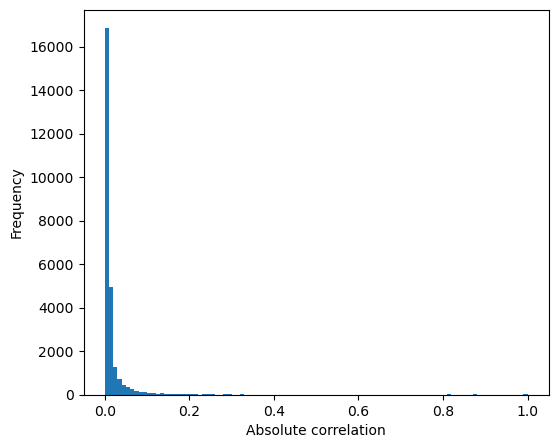

In [9]:
# Plot frequency of each correlation
fig, ax = plt.subplots(figsize=(6, 5))
bins = np.arange(min(corr['abs_value']), max(corr['abs_value'])+0.01, 0.01)
ax.hist(corr['abs_value'], bins=bins)
ax.set_xlabel('Absolute correlation')
ax.set_ylabel('Frequency')
plt.show()

In [10]:
# Count proportion of results in the following bins
bins = [0, 0.10, 0.25, 0.5, 0.75, 0.99, 1.1]
counts = np.histogram(corr['abs_value'], bins=bins)[0]
counts = counts / counts.sum()*100

labels = ['<0.10', '0.1 to 0.25', '0.25 to 0.50', '0.50 to 0.75',
          '0.75 to 0.999', '1']
counts_df = pd.DataFrame(index=labels)
counts_df['percent'] = counts
counts_df['cumulative_percent'] = counts.cumsum()
counts_df.index.name = 'abs_value'
counts_df

,percent,cumulative_percent
abs_value,,
<0.10,96.665139,96.665139
0.1 to 0.25,2.120101,98.785240
0.25 to 0.50,0.618840,99.404080
0.50 to 0.75,0.160440,99.564520
0.75 to 0.999,0.385820,99.950340
1,0.049660,100.000000


In [11]:
# Find rows where it is a relationship with missing a variable
missing_rows = (corr['variable'].str.contains('missing') |
                corr.index.str.contains('missing'))

### Correlations greater than +- 0.5 (that are not relationships with whether a variable is missing)

In [12]:
# Show highly correlated features (exc. missing)
corr[(corr['abs_value'] >= 0.5) & (~missing_rows)]

,variable,value,abs_value
death,discharge_destination_died,1.0000,1.0000
thrombolysis_no_but_haemorrhagic,infarction,-0.9857,0.9857
nihss_arrival_motor_leg_right,nihss_arrival_motor_arm_right,0.7616,0.7616
nihss_arrival_motor_leg_left,nihss_arrival_motor_arm_left,0.7606,0.7606
afib_anticoagulant,afib_doac_anticoagulant,0.7058,0.7058
nihss_arrival_loc_commands,nihss_arrival_loc_questions,0.6664,0.6664
nihss_arrival_loc_questions,nihss_arrival_best_language,0.6546,0.6546
atrial_fibrillation,afib_anticoagulant,0.6533,0.6533
stroke_severity,nihss_arrival_loc_questions,0.6202,0.6202
onset_to_arrival_time,thrombolysis_no_but_time_window,0.6131,0.6131


**Relationships within NIHSS**

| Variable | Variable | Likely explanation for correlation |
| --- | --- | --- |
| nihss_arrival_motor_leg_right | nihss_arrival_motor_arm_right | Level of motor drift in right leg correlates with level in right arm (leg and arm weakness are very common symptoms) |
| nihss_arrival_motor_leg_left | nihss_arrival_motor_arm_left | Level of motor drift in left left correlates with level in left arm (leg and arm weakness are very common symptoms) |
| nihss_arrival_loc_commands | nihss_arrival_loc_questions | People with low level of consciousness will struggle with both the questions and commands |
| nihss_arrival_loc_questions | nihss_arrival_best_language | People with poor language abilities will struggle to answer the level of consciousness questions |
| stroke_severity | nihss_arrival_loc_questions | Stroke severity is total NIHSS, and other variable contributes to that |
| stroke_severity | nihss_arrival_extinction_inattention | Stroke severity is total NIHSS, and other variable contributes to that |
| nihss_arrival_best_language | nihss_arrival_loc_commands | Each variable is a different indicator of stroke severity |
| nihss_arrival_best_language | stroke_severity | Stroke severity is total NIHSS, and other variable contributes to that |
| nihss_arrival_dysarthria | stroke_severity | Stroke severity is total NIHSS, and other variable contributes to that |
| stroke_severity | nihss_arrival_facial_palsy | Stroke severity is total NIHSS, and other variable contributes to that |
| nihss_arrival_loc_commands | stroke_severity | Stroke severity is total NIHSS, and other variable contributes to that |
| nihss_arrival_extinction_inattention | nihss_arrival_best_gaze | Each variable is a different indicator of stroke severity |
| nihss_arrival_loc_commands | nihss_arrival_loc | Each variable is a different indicator of stroke severity |
| stroke_severity | nihss_arrival_motor_leg_right | Stroke severity is total NIHSS, and other variable contributes to that |
| nihss_arrival_best_gaze | stroke_severity | Stroke severity is total NIHSS, and other variable contributes to that |
| discharge_disability | stroke_severity | Stroke severity is total NIHSS, and other variable contributes to that |
| nihss_arrival_visual | nihss_arrival_extinction_inattention | Each variable is a different indicator of stroke severity |
| nihss_arrival_motor_leg_left | stroke_severity | Stroke severity is total NIHSS, and other variable contributes to that |
| nihss_arrival_visual | nihss_arrival_best_gaze | Each variable is a different indicator of stroke severity |
| nihss_arrival_motor_arm_right | stroke_severity | Stroke severity is total NIHSS, and other variable contributes to that |

**Logical relationships** (ie. due to nature of variables)

| Variable | Variable | Likely explanation for correlation |
| --- | --- | --- |
| discharge_destination_died | death | Death is a measure of whether were dead at discharge |
| infarction | thrombolysis_no_but_haemorrhagic | Infarction is a measure of whether or not a stroke was haemorrhagic |
| afib_doac_anticoagulant | afib_anticoagulant | Anticoagulant is a measure of taking any type of anticoagulant, and DOAC is a specific type |
| thrombolysis_no_but_time_window | onset_to_arrival_time | One is indicator that didn't receive thrombolysis as arrived too late and other is time to arrive |
| discharge_disability | death | Death is a measure of death at discharge, so relates to disability at discharge (where 6 is death) |
| discharge_destination_died | discharge_disability| Discharge desination is a measure of death at discharge, so relates to disability at discharge (where 6 is death) | 

**Other relationships**

| Variable | Variable | Likely explanation for correlation |
| --- | --- | --- |
| atrial_fibrillation | afib_anticoagulant | People with atrial fibrillation will often be prescribed anticoagulants |
| disability_6_month | discharge_disability| Appears to be relationship between discharge disability and disability at six months |
| discharge_destination_community_team_or_esd | discharge_destination_home | These are the two most common discharge locations, so if you're not one there's a reasonable chance you're the other |

### Correlations greater than +- 0.5 (that ARE relationships with whether a variable is missing)

In [13]:
# Show highly correlated features (only "missing" indicators) that are over 0.7
corr[(corr['abs_value'] >= 0.7) & (missing_rows)]

,variable,value,abs_value
onset_to_arrival_time_missing,onset_known,-1.0000,1.0000
ambulance_travel_to_hospital_time_missing,call_to_ambulance_arrival_time_missing,1.0000,1.0000
ambulance_travel_to_hospital_time_missing,ambulance_on_scene_time_missing,1.0000,1.0000
afib_heparin_anticoagulant_missing,afib_vit_k_anticoagulant_missing,1.0000,1.0000
ambulance_wait_time_at_hospital_missing,ambulance_on_scene_time_missing,1.0000,1.0000
call_to_ambulance_arrival_time_missing,ambulance_on_scene_time_missing,1.0000,1.0000
afib_heparin_anticoagulant_missing,afib_doac_anticoagulant_missing,1.0000,1.0000
afib_doac_anticoagulant_missing,afib_vit_k_anticoagulant_missing,1.0000,1.0000
scan_to_thrombolysis_time_missing,thrombolysis,-1.0000,1.0000
thrombectomy,arrival_to_thrombectomy_time_missing,-1.0000,1.0000


Looking at +-0.7 or above, overall patterns (with stronger relationships for some than others):

| Variable | Variable | Likely explanation for correlation |
| --- | --- | --- |
| Onset to arrival time missing | Onset known | Onset known measures whether onset to arrival time is missing |
| Time to treatment missing | Whether received treatment | Will only have a time if received the treatment |
| Ambulance time missing | Ambulance time missing | If missing one, tend to be missing the other |
| NIHSS score missing | NIHSS score missing | If missing one, tend to be missing the other |
| Anticoagulant missing | Anticoagulant missing | If missing one, tend to be missing the other |
| Discharge disability missing | Discharge destination missing | If missing one, tend to be missing the other |

In [14]:
# Show strong correlations of 0.5 or 0.5
corr[(corr['abs_value'] >= 0.5) & (corr['abs_value'] < 0.7) & (missing_rows)]

,variable,value,abs_value
year,afib_anticoagulant_missing,-0.6960,0.6960
afib_anticoagulant_missing,new_afib_diagnosis_missing,0.6406,0.6406
afib_anticoagulant,new_afib_diagnosis_missing,0.6166,0.6166
year,new_afib_diagnosis_missing,-0.5968,0.5968
new_afib_diagnosis_missing,atrial_fibrillation,0.5240,0.5240
year,ambulance_on_scene_time_missing,-0.5130,0.5130
ambulance_travel_to_hospital_time_missing,year,-0.5130,0.5130
ambulance_wait_time_at_hospital_missing,year,-0.5130,0.5130
call_to_ambulance_arrival_time_missing,year,-0.5130,0.5130


Looking at +- 0.5 to 0.7:

| Variable | Variable | Likely explanation for correlation |
| --- | --- | --- |
| afib_anticoagulant_missing | year | This variable appears to be missing moreso in some years than others |
| new_afib_diagnosis_missing | Anticoagulant (variable or missing), year, or atrial fibrillation | Missing a new afib diagnosis appears to correlate with these variables |
| year | Ambulance times missing | Ambulance times appear to be missing moreso in some years than others |

### Any correlations +- 0.4 to 0.5

In [15]:
# Show moderate correlations of 0.4 or higher
corr[(corr['abs_value'] >= 0.4) & (corr['abs_value'] < 0.5)]

,variable,value,abs_value
precise_onset_known,onset_to_arrival_time_missing,-0.4992,0.4992
precise_onset_known,onset_known,0.4992,0.4992
death,nihss_arrival_loc,0.4847,0.4847
discharge_destination_died,nihss_arrival_loc,0.4846,0.4846
stroke_severity,nihss_arrival_sensory,0.4762,0.4762
discharge_disability,discharge_destination_home,-0.4733,0.4733
nihss_arrival_dysarthria,nihss_arrival_facial_palsy,0.4716,0.4716
prior_disability,discharge_disability,0.4704,0.4704
stroke_severity,nihss_arrival_loc,0.4686,0.4686
nihss_arrival_motor_arm_left,stroke_severity,0.4647,0.4647


Looking at +- 0.4 to 0.5:

Correlations within NIHSS:
| Variable | Variable |
| --- | --- |
| stroke_severity | nihss_arrival_sensory |
| nihss_arrival_dysarthria | nihss_arrival_facial_palsy |
| stroke_severity | nihss_arrival_loc |
| nihss_arrival_motor_arm_left | stroke_severity |
| nihss_arrival_loc | nihss_arrival_loc_questions |
| stroke_severity | nihss_arrival_visual |
| nihss_arrival_extinction_inattention | nihss_arrival_sensory |
| nihss_arrival_best_gaze | nihss_arrival_loc |
| nihss_arrival_loc | nihss_arrival_best_language |
| nihss_arrival_best_language | nihss_arrival_dysarthria |
| nihss_arrival_best_gaze | nihss_arrival_loc_commands |
| nihss_arrival_best_language | nihss_arrival_motor_arm_right |
| nihss_arrival_motor_leg_right | nihss_arrival_best_language |
| nihss_arrival_loc_commands | nihss_arrival_motor_leg_right |

Correlations relating to whether time was known:
| Variable | Variable |
| --- | --- |
| precise_onset_known | onset_to_arrival_time_missing or onset_known |
| precise_onset_known | thrombolysis_no_but_time_unknown_wake_up |
| onset_known | thrombolysis_no_but_time_unknown_wake_up |
| thrombolysis_no_but_time_unknown_wake_up | onset_to_arrival_time_missing |

Correlations between death/disability and stroke severity/NIHSS items:
| Variable | Variable |
| --- | --- |
| death or discharge_destination_died | nihss_arrival_loc |
| discharge_disability | nihss_arrival_loc_questions |
| death | nihss_arrival_loc_commands |
| discharge_destination_died | nihss_arrival_loc_commands |
| discharge_disability | nihss_arrival_loc |
| nihss_arrival_loc_commands | discharge_disability |
| death | stroke_severity |
| discharge_destination_died | stroke_severity |

Correlations with anticoagulant use:
| Variable | Variable |
| --- | --- |
| atrial_fibrillation | afib_doac_anticoagulant |
| afib_anticoagulant | thrombolysis_no_but_medication |
| afib_anticoagulant | afib_vit_k_anticoagulant |

Other correlations:
| Variable | Variable |
| --- | --- |
| discharge_disability | discharge_destination_home |
| prior_disability | discharge_disability |
| prior_disability | disability_6_month |
| age | prior_disability |